# Build and Compare Sound Speed Models
This is done using existing CTD data (example is from a deep-water cast collected in 2024 near the AK trench)


In [1]:
import numpy as np
import matplotlib.pyplot as plt
# pip install seabird (read CTD data from UNOLS)
from seabird.cnv import fCNV

# ray tracing
from OceanRays.SoundSpeed import CTDSoundSpeed

/Users/an77/anaconda3/envs/oceanrays/lib/python3.13/site-packages/seabird/cnv.py:3: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


In [2]:
# Build a Sound Speed Profile using existing CTD data (example is from a deep-water cast collected in 20204 near the AK trench)

# From CTD Data
infile='../CTD_examples/SKQ202409S_009avg.cnv'
profile = fCNV(infile) 

# see what variables are available
profile.keys()

['DEPTH',
 'LATITUDE',
 'LONGITUDE',
 'PRES',
 'TEMP',
 'TEMP2',
 'potemperature',
 'PSAL',
 'PSAL2',
 'density',
 'sigma-�00',
 'oxsolMm/Kg',
 'v0',
 'v1',
 'CStarAt0',
 'scan',
 'timeM',
 'nbin',
 'flag']

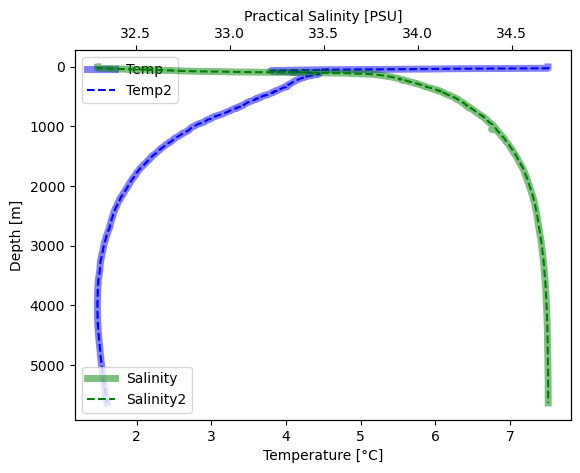

In [3]:
# plotting input data 
plt.plot(profile['TEMP'],profile['DEPTH'], 'b', alpha=0.5,linewidth=5, label='Temp')
plt.plot(profile['TEMP2'],profile['DEPTH'], 'b--', label='Temp2')
plt.legend()
plt.xlabel('Temperature [°C]')
plt.ylabel('Depth [m]')

plt.twiny()
plt.plot(profile['PSAL'],profile['DEPTH'], 'g',alpha=0.5,linewidth=5, label='Salinity')
plt.plot(profile['PSAL2'],profile['DEPTH'], 'g--', label='Salinity2')
plt.gca().invert_yaxis()
plt.legend()
plt.xlabel('Practical Salinity [PSU]')
plt.show()


In [4]:
# convert to sound speed using the MacKenzie equation
#   A few different model options are available, including also 
#   Leroy, Coppens, DelGrosso, and Chen_Millero (UNESCO)

CMac = CTDSoundSpeed(profile,model='Mackenzie')

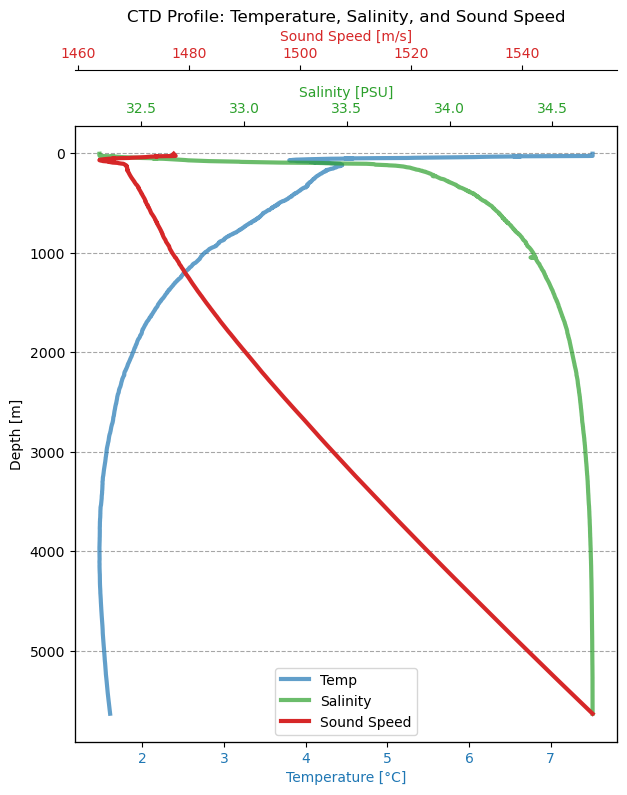

In [5]:

# Now plot with three clear x-axes: Temp, Salinity, Sound Speed
fig, ax1 = plt.subplots(figsize=(7,8))

color1 = 'tab:blue'
color2 = 'tab:green'
color3 = 'tab:red'

# First x-axis: Temperature
ax1.plot(profile['TEMP'], profile['DEPTH'], color=color1, linewidth=3, alpha=0.7, label='Temp')
ax1.set_xlabel('Temperature [°C]', color=color1)
ax1.tick_params(axis='x', labelcolor=color1)
ax1.set_ylabel('Depth [m]')
ax1.invert_yaxis()

# Second x-axis: Salinity
ax2 = ax1.twiny()
ax2.plot(profile['PSAL'], profile['DEPTH'], color=color2, linewidth=3, alpha=0.7, label='Salinity')
ax2.set_xlabel('Salinity [PSU]', color=color2)
ax2.tick_params(axis='x', labelcolor=color2)

# Third x-axis: Sound Speed
ax3 = ax1.twiny()
ax3.spines['top'].set_position(('outward', 40))
ax3.plot(CMac, profile['DEPTH'], color=color3, linewidth=3, label='Sound Speed')
ax3.set_xlabel('Sound Speed [m/s]', color=color3)
ax3.tick_params(axis='x', labelcolor=color3)

# Add legends for each axis
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
lines3, labels3 = ax3.get_legend_handles_labels()
ax1.legend(lines1 + lines2 + lines3, labels1 + labels2 + labels3, loc='lower center')

ax1.grid(axis='y', which='both', linestyle='--', color='gray', alpha=0.7)
plt.title('CTD Profile: Temperature, Salinity, and Sound Speed')
plt.show()

In [6]:
# Frequently, you may have a pre-computed sound speed profile from a CTD cast

# from CTD data (svp = sound velocity profile)
svpfile='../CTD_examples/SKQ202409S_009svp.cnv'
#  Apparently the user can select one of 3 models for calculating the sound speed within seabird.  
#  The above example follows Chen-Millero (can find details in the header of the .cnv file).
#
#  More info here: https://www.seabird.com/asset-get.download.jsa?id=69833853363
#  
#  The above document suggests Chen - Millero (1977) may be better for shallow waters (e.g. above shelf)
#  and Del Grosso (1974) may be better for deep waters.
    
svpprofile = fCNV(svpfile) 
print(svpprofile.keys())

['DEPTH', 'LATITUDE', 'LONGITUDE', 'TEMP', 'PSAL', 'soundspeed', 'flag']


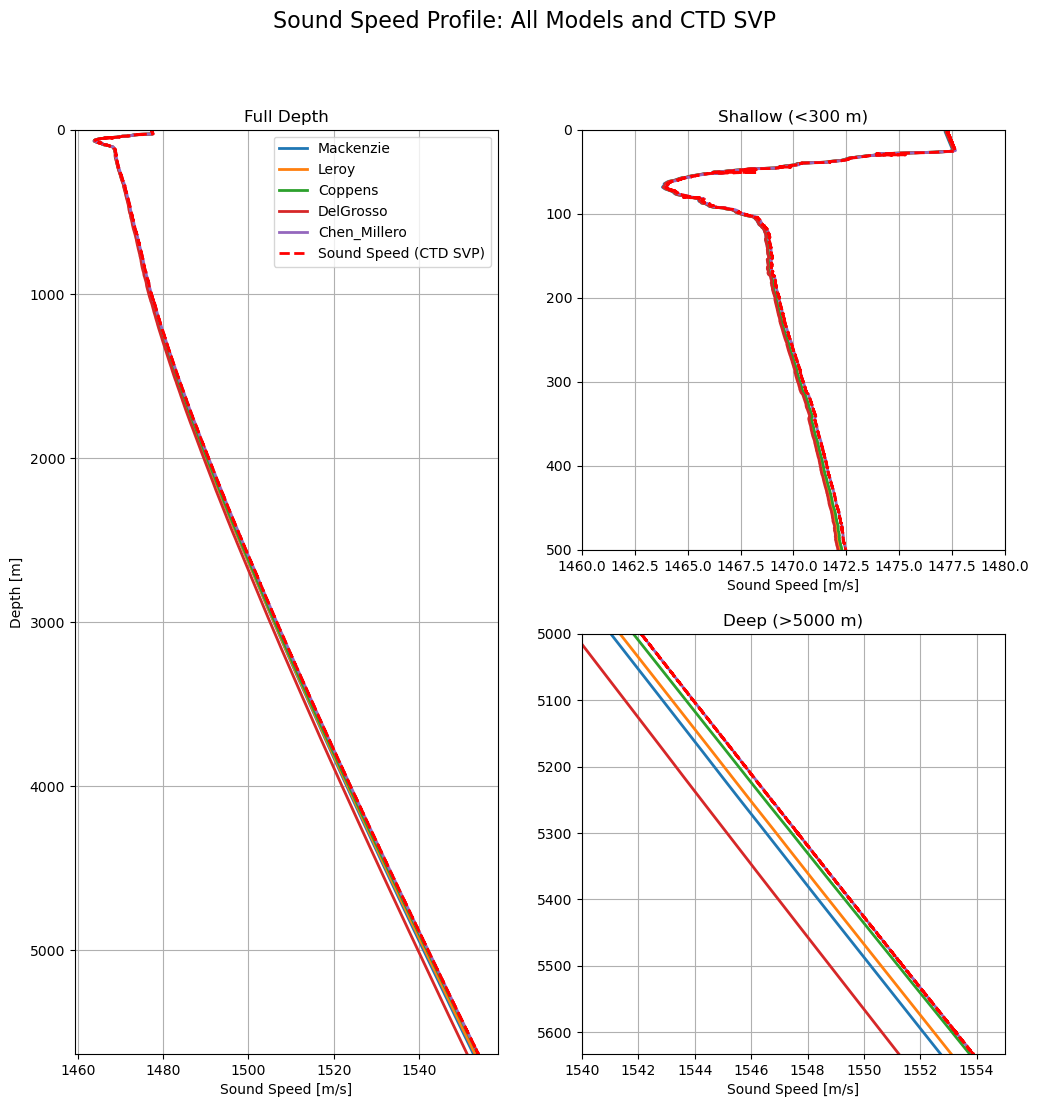

In [10]:

# plot all available sound speed models
models = ['Mackenzie','Leroy','Coppens','DelGrosso','Chen_Millero']
C_models = [CTDSoundSpeed(profile, model=m) for m in models]
depth = profile['DEPTH']
svp_speed = svpprofile['soundspeed']
svp_depth = svpprofile['DEPTH']

fig = plt.figure(figsize=(12,12))
gs = fig.add_gridspec(2,2)

# Main panel: full depth
ax_main = fig.add_subplot(gs[:,0])
for C, m in zip(C_models, models):
    ax_main.plot(C, depth, lw=2, label=m)
ax_main.plot(svp_speed, svp_depth, 'r--', lw=2, label='Sound Speed (CTD SVP)')
ax_main.set_xlabel('Sound Speed [m/s]')
ax_main.set_ylabel('Depth [m]')
ax_main.invert_yaxis()
ax_main.set_ylim(max(depth), 0)
ax_main.set_title('Full Depth')
ax_main.legend()
ax_main.grid(True)

# Right top: shallow zoom (<300 m)
ax_shallow = fig.add_subplot(gs[0,1])
for C, m in zip(C_models, models):
    ax_shallow.plot(C, depth, lw=2, label=m)
ax_shallow.plot(svp_speed, svp_depth, 'r--', lw=2, label='Sound Speed (CTD SVP)')
ax_shallow.set_ylim(500, 0)
ax_shallow.set_xlim(1460, 1480)
ax_shallow.set_xlabel('Sound Speed [m/s]')
ax_shallow.set_title('Shallow (<300 m)')
ax_shallow.grid(True)

# Right bottom: deep zoom (>5000 m)
ax_deep = fig.add_subplot(gs[1,1])
for C, m in zip(C_models, models):
    ax_deep.plot(C, depth, lw=2, label=m)
ax_deep.plot(svp_speed, svp_depth, 'r--', lw=2, label='Sound Speed (CTD SVP)')
ax_deep.set_ylim(max(depth), 5000)
ax_deep.set_xlim(1540, 1555)
ax_deep.set_xlabel('Sound Speed [m/s]')
ax_deep.set_title('Deep (>5000 m)')
ax_deep.grid(True)

plt.suptitle('Sound Speed Profile: All Models and CTD SVP', fontsize=16)
plt.show()